In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

n_samples = len(X_test)

In [2]:
# one hot encoding
y_train_encoded = np.eye(43)[y_train]
y_test_encoded = np.eye(43)[y_test]

In [3]:
img_size =32
img_size_flat = img_size *  img_size *3
img_shape = (img_size, img_size ,3)
num_classes = 43

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])
        

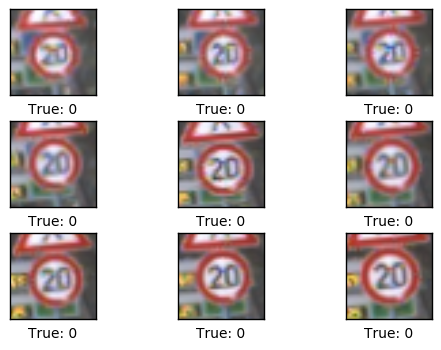

In [5]:
images = X_train[0:9]
cls_true = y_train[0:9]
plot_images(images = images, cls_true = cls_true)

In [6]:
x = tf.placeholder(tf.float32, [None,  32,32,3])
x


<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 3) dtype=float32>

In [7]:
x_flat = tf.reshape(x, [-1, img_size_flat])
x_flat

<tf.Tensor 'Reshape:0' shape=(?, 3072) dtype=float32>

In [8]:
# this is the representation of the Y labels in the one hot encoded
y = tf.placeholder(tf.float32, [None, num_classes])
y
 

<tf.Tensor 'Placeholder_1:0' shape=(?, 43) dtype=float32>

In [9]:
y_true_cls = tf.placeholder(tf.int64, [None]) # this is the regular vertion : an idex of numbers which are the labels

# network and hyper  parameters


In [10]:
n_hidden_1 = 1256
n_hidden_2 = 1256

# hyper parameters
learning_rate = 0.25
training_epochs = 10
batch_size = 50
display_step = 1


# weights and biases

In [11]:
weights = {
    'h1': tf.Variable(tf.zeros([img_size_flat,n_hidden_1])),
    'h2': tf.Variable(tf.zeros([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.zeros([n_hidden_2,num_classes])) 
}

In [12]:
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

# build the model (multi-layer) 

In [13]:
# layer 1
layer_1 = tf.add(tf.matmul(x_flat, weights['h1']), biases['b1'])
layer_1 = tf.nn.relu(layer_1)

In [14]:
# layer 2
layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
layer_2 = tf.nn.relu(layer_2)

In [15]:
# output layer
out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

In [16]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out_layer, y))

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

In [18]:
y_pred = tf.nn.softmax(out_layer) # where the logit come out

In [19]:
y_pred_cls = tf.argmax(y_pred, dimension = 1)

In [20]:
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(out, y)

In [21]:
# cost = tf.reduce_mean(cross_entropy)

In [22]:
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

In [23]:
correct_prediction = tf.equal(y_pred_cls, y_train)

In [24]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
init = tf.initialize_all_variables()

# Tensorflow session


In [26]:
start_time= time.time()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples/batch_size)
        
        for batch_i in range(total_batch):
            
            batch_start = batch_i*batch_size
            batch_x = X_train[batch_start:batch_start + batch_size]
            batch_y = y_train_encoded[batch_start:batch_start + batch_size]
            
            
            
            _,c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            avg_cost+= c/total_batch
            
        if epoch % display_step == 0:
            print ("Epoch: ", '%04d' % (epoch+1), "cost=", avg_cost) 
            
    print("optimization finished!") 
    
    correct_prediction = tf.equal(y_pred_cls, y_test)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    end_time = time.time()
    compute_time = end_time-start_time
    
    print("accuracy: ", accuracy.eval({x: X_test, y: y_test_encoded}))
    print("time usage: " + str(timedelta(seconds= int(round(compute_time)))))

Epoch:  0001 cost= 1.82729704625
Epoch:  0002 cost= 1.46705029804
Epoch:  0003 cost= 1.39759183811
Epoch:  0004 cost= 1.36489485594
Epoch:  0005 cost= 1.34698245902
Epoch:  0006 cost= 1.33584481451
Epoch:  0007 cost= 1.32829982669
Epoch:  0008 cost= 1.32286960232
Epoch:  0009 cost= 1.31878434911
Epoch:  0010 cost= 1.3156038008
optimization finished!
accuracy:  0.0356295
time usage: 0:01:03
